# Сборный проект. Определение закономерностей, влиляющих на успешность игр.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение данных из файла. Предобработка данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
try:
    url = 'https://drive.google.com/file/d/13z0Bbhm3eZziiNyKrkjmzPwaN0BLcmRb/view?usp=sharing'
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    df = pd.read_csv(path)
except:
    raise

Импортируем основные библиотеки и прочтем датасет.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Первичный просмотр информации о датасете выявил 2 незаполненных наименования игры, пропуски в поле "год выпуска", 2 пропуска в поле "жанр" (видимо те же записи, в которых не заполнено наименование). Поля с оценками и рейтингом также заполнены не все. Изучим поля более детально на наличие аномалий и пропусков.

In [4]:
new_name = ['name',  'platform', 'year_of_release', 'genre', 'na_sales','eu_sales','jp_sales','other_sales','critic_score','user_score','rating']
df.set_axis(new_name, axis = 'columns', inplace = True)

Приведем наименования столбцов к нижнему регистру.

In [5]:
cols = df.columns[:14]
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    print('{} - {}%'.format(col, pct_missing*100))

name - 0.011965300628178284%
platform - 0.0%
year_of_release - 1.609332934489979%
genre - 0.011965300628178284%
na_sales - 0.0%
eu_sales - 0.0%
jp_sales - 0.0%
other_sales - 0.0%
critic_score - 51.31917439425665%
user_score - 40.08973975471134%
rating - 40.478612025127134%


Исследуем записи с пропущенными названиями игр. Как видно, это те же игры, жанр для которых не указан. Из данных есть только объемы продаж в регионах и год выпуска - 1993. Предлагается удалить их из датасета, это не повлияет на результаты анализа. 

In [6]:
df=df.dropna(subset = ['genre'])

In [7]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

Поле platform не требует предобработки.

In [8]:
df['year_of_release'].value_counts().sort_index()

1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      60
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: year_of_release, dtype: int64

Годы релизов игр - от 1980 до 2016. Пропущенных значений 269, что составляет 1,61% от всего датасета. Это незначимая часть датасета, можно удалить эти данные.

In [9]:
df=df.dropna(subset = ['year_of_release'])

In [10]:
df['year_of_release'] = df['year_of_release'].astype(int)

Изменим тип данных поля year_of_release c float на int

In [11]:
df['genre'].value_counts()

Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
Name: genre, dtype: int64

Наименования в поле "Жанр" не требуют предобработки.

Значений NaN в полях NA_sales, EU_sales, JP_sales и Other_sales не обнаружено.

In [12]:
len(df.query('na_sales==0'))

4449

In [13]:
len(df.query('eu_sales==0'))

5766

In [14]:
len(df.query('jp_sales==0'))

10300

In [15]:
len(df.query('other_sales==0'))

6492

В полях sales - до трети нулевых значений от общего объема датафрейма. В большей степени неизвестны продажи игр в Японии, затем - в прочих регионах. Для Японии пропуски могут быть связаны с языковой локализацией. По прочим регионам количество пропусков относительно сопоставимо. Проверим гипотезу: нулевые продажи по прочим (неяпонским) регионам в основном составляют локализованные для Японии игры.

In [16]:
df.query('na_sales==0 and eu_sales==0 and other_sales==0 and jp_sales!=0').count()

name               3127
platform           3127
year_of_release    3127
genre              3127
na_sales           3127
eu_sales           3127
jp_sales           3127
other_sales        3127
critic_score         90
user_score          120
rating              125
dtype: int64

В получившемся датафрейме - 3 127 записей. Примем следующую гипотезу - эти 3 127 игры локализованы для японского рынка.

In [17]:
df.query('na_sales!=0 and eu_sales==0 and other_sales==0 and jp_sales==0').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
881,Who wants to be a millionaire,PC,1999,Misc,1.94,0.0,0.0,0.0,NaN,tbd,E
962,The Sims: Hot Date,PC,2001,Simulation,1.81,0.0,0.0,0.0,85.0,7.9,T
1080,The Sims: Superstar,PC,2003,Simulation,1.67,0.0,0.0,0.0,79.0,8.2,T
1207,Command & Conquer: Tiberian Sun,PC,1999,Strategy,1.55,0.0,0.0,0.0,NaN,NaN,NaN
4595,SpongeBob's Truth or Square (US sales),DS,2009,Action,0.42,0.0,0.0,0.0,NaN,NaN,NaN


In [18]:
df.query('na_sales!=0 and eu_sales==0 and other_sales==0 and jp_sales==0').count()

name               949
platform           949
year_of_release    949
genre              949
na_sales           949
eu_sales           949
jp_sales           949
other_sales        949
critic_score       422
user_score         741
rating             734
dtype: int64

Проверим аналогичную гипотезу для североамериканского рынка. Таких записей - 941. В датасете для игры SpongeBob's Truth or Square видна пометка "US sales". Можно выдвинуть гипотезу о том, что эти игры предназначены для продажи только в Америке. Но доля проданных только в США игр составляет только 4 часть от всех нулевых значений в поле na_sales. Поэтому принимать эту гипотезу не совсем корректно. Заполнить пропуски медианами или средними даже с учетом жанра игры также будет некорректно, игра могла не продаваться в этом регионе и статистика продаж будет искажена в большую сторону. В реальных условиях здесь может помочь консультация с заказчиком исследования или менеджерами департамента продаж. В текущих условиях предлагается оставить нулевые значения нулевыми и счиать, что продаж в этих регионах не было.

In [19]:
df['critic_score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

В поле critic_score - 8463 значения NaN. Вполне правдоподобно, оценки критиков могут отсутствовать в датафрейме. Корректно заполнить эти пропуски не представляется возможным. Заменим NaN на нули.

In [20]:
df['critic_score']=df['critic_score'].fillna(0)

Исходя из распределения оценка критиков выставляется по 100-балльной шкале. В распределении минимальный балл -13, максимальный - 98.

In [21]:
df['critic_score'] = df['critic_score'].astype(int)

Заменим тип значений в поле critic_score на целочисленный, т.к. оценка выставляется в целых числах.

In [22]:
len(df.query('user_score=="tbd"'))

2376

В поле user_score - 6607 значений NaN и 2376 значений tbd (to be done, оценки еще нет). Заменим NaN и tbd на нули.

In [23]:
df['user_score']=df['user_score'].fillna(0)

In [24]:
df.loc[(df.user_score =="tbd"), 'user_score'] = 0

In [25]:
len(df.query('user_score=="tbd"'))

0

Значения NaN и tbd заменены на нули.

In [26]:
df['user_score'] = df['user_score'].astype(float)

In [27]:
df['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

In [28]:
df['rating'] = df['rating'].fillna(0)

Заменим на нули пропуски в поле rating

In [29]:
df['total_sales'] = df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']
df.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14086,Obscure,XB,2004,Adventure,0.03,0.01,0.00,0.00,66,8.4,M,0.04
865,Devil May Cry 2,PS2,2003,Action,0.71,0.58,0.51,0.17,68,6.6,M,1.97
10344,Hyper Formation Soccer,PS,1995,Sports,0.00,0.00,0.10,0.01,0,0.0,0,0.11
13084,DokiDoki Majo Shinpan!,DS,2007,Adventure,0.00,0.00,0.05,0.00,0,0.0,0,0.05
3545,Bratz 4 Real,DS,2007,Adventure,0.29,0.22,0.00,0.06,0,0.0,E,0.57


In [30]:
df['na_sales'] = df['na_sales'].fillna(0)
df['eu_sales'] = df['eu_sales'].fillna(0)
df['jp_sales'] = df['jp_sales'].fillna(0)
df['other_sales'] = df['other_sales'].fillna(0)

## Исследовательский анализ данных

### Анализ продаж и релизов игр за весь период

In [31]:
qty_per_year = df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count').reset_index()

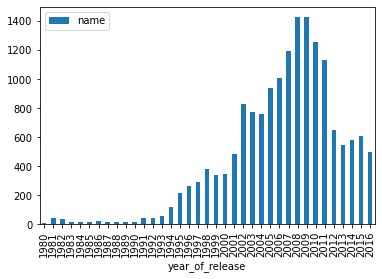

In [32]:
qty_per_year.plot(x='year_of_release', y ='name', kind = 'bar');

На диаграмме видно, что активный рост количества выпущенных игр начался примерно с 1994 года.

In [33]:
sls_per_year = df.pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum').reset_index()

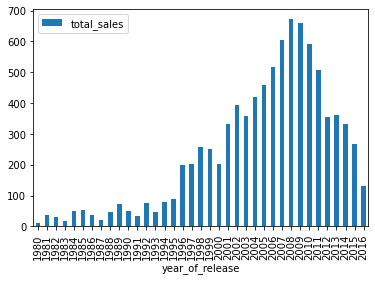

In [34]:
sls_per_year.plot(x='year_of_release', y ='total_sales', kind = 'bar');

На диаграмме с количеством проданных копий видно, что до 1996 года игр продавалось на порядок меньше.  Предлагается анализировать игры с датой релиза не позднее 1996 года. 

In [35]:
df = df.query('year_of_release > 1995')

In [36]:
platform_sales = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').reset_index()
platform_sales.sort_values(by = 'total_sales', ascending = False)

,platform,total_sales
11,PS2,1233.56
21,X360,961.24
12,PS3,931.34
19,Wii,891.18
2,DS,802.76
10,PS,685.59
13,PS4,314.14
4,GBA,312.88
14,PSP,289.53
0,3DS,257.81


Проанализируем платформы в зависимости от количества проданных копий игр за период с 1996 года

In [37]:
platform_sales = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').reset_index()
platform_sales.sort_values(by = 'total_sales', ascending = False)

,platform,total_sales
11,PS2,1233.56
21,X360,961.24
12,PS3,931.34
19,Wii,891.18
2,DS,802.76
10,PS,685.59
13,PS4,314.14
4,GBA,312.88
14,PSP,289.53
0,3DS,257.81


Также построим сводную с рейтингом продаж за весь период (для исследования жизненного цикла платформ)

### Анализ продаж игр в разрезе платформ

In [38]:
big_lst = list(platform_sales.query('total_sales > 100').sort_values(by ='total_sales', ascending = False)['platform'])

Создадим список платформ с более чем 100 млн. проданных копий за весь период.

In [39]:
platform_years_sales = df.pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum').reset_index()

Для анализа распределений по годам сформируем сводную platform_years_sales.

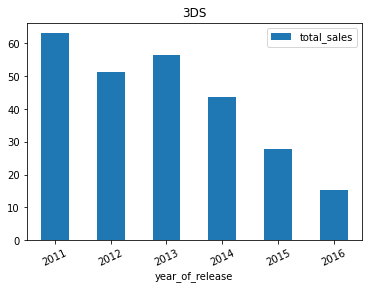

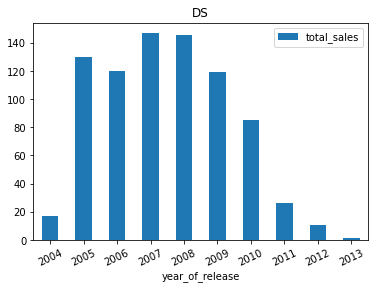

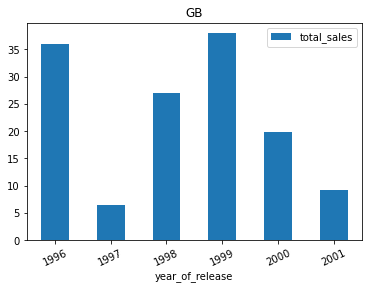

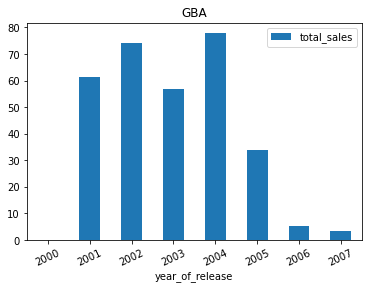

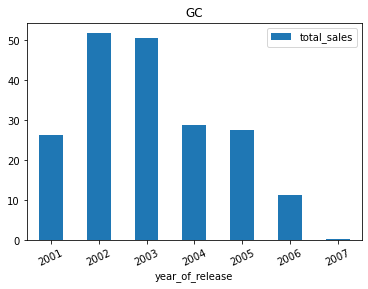

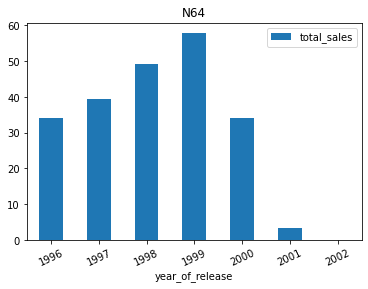

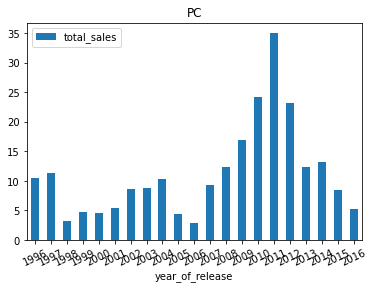

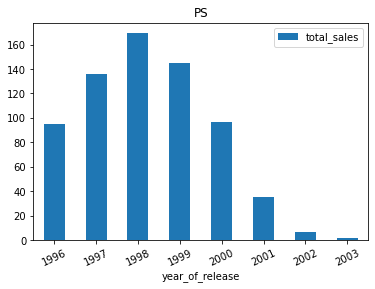

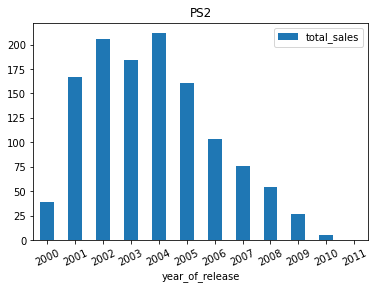

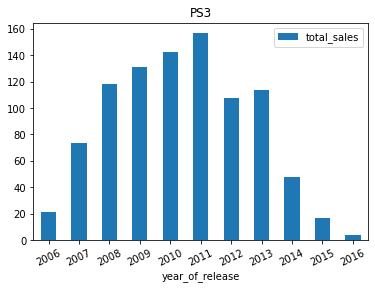

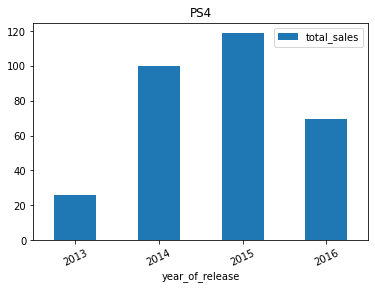

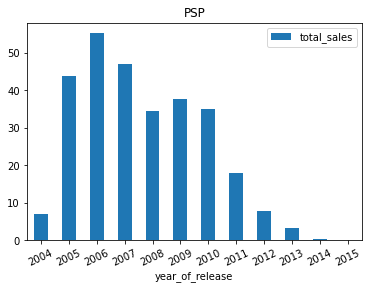

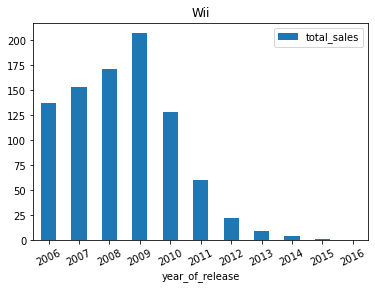

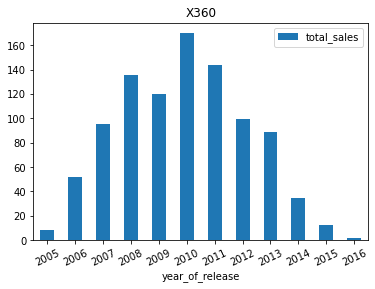

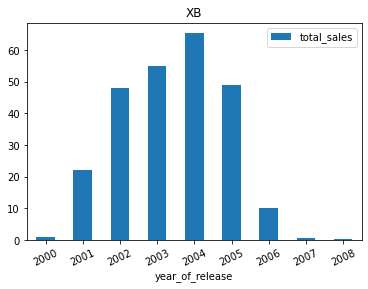

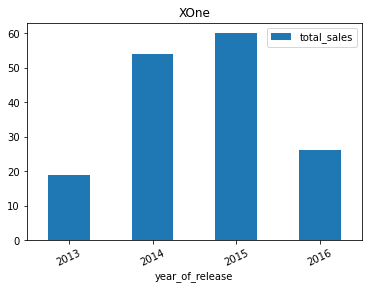

In [40]:
for name, group_data in platform_years_sales.groupby('platform'):
    if name in big_lst:
        group_data.plot(x='year_of_release', y='total_sales', kind = 'bar', title = name, rot = 25)
        plt.show()

Построим графики распределений проданных копий по годам.

### Анализ средней продолжительности жизненного цикла платформы

In [41]:
big_lst_PC_free = list(platform_sales.query('total_sales > 100 and platform!="PC"').sort_values(by ='total_sales', ascending = False)['platform'])

Создадим список крупных платформ (от 100 млн. проданных копий), но без учета PC, т.к. персональный компьютер не является полноценной игровой платформой, отличие его от игровых платформ - многофункциональность, использование для работы, применение жизненного цикла неприменимо к нему.

In [42]:
platform_years_sales_avg_cycle = df.query('platform in @big_lst_PC_free').pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum').reset_index()
platform_years_sales_avg_cycle = platform_years_sales_avg_cycle.pivot_table(index = 'platform', values = 'year_of_release', aggfunc = 'count').reset_index()

По графикам видно, что средний срок "активной" жизни платформы - 6 лет (без учета года появления и года исчезновения). Проверим эту гипотезу. Сформируем сводную без учета PC и сформируем вспомогательную сводную для расчета среднего количества лет существования платформы platform_years_sales_avg_cycle. Посчитаем количество повторений "год-платформа" и выведем распределение этого числа. 

In [43]:
platform_years_sales_avg_cycle['year_of_release'].describe()

count    15.000000
mean      8.466667
std       2.799660
min       4.000000
25%       6.500000
50%       8.000000
75%      11.000000
max      12.000000
Name: year_of_release, dtype: float64

 Распределение показывает среднее значение 8,4 года и медиану 8 лет. Вывод - полный цикл существования игровой платформы с момента появления до окончания существования принимаем равным 8 годам.

Исходя из графиков распределения и среднего цикла жизни платформы можно выделить самые перспективные платформы на 2017 год: PS4, XOne, 3DS (жизненный цикл не завершен) и PC (исходя из того, что к PC неприменимо понятие жизненного цикла и игры на него будут выходить всегда). 
Лидеры продаж по объемам: PS2, X360, PS3, Wii от Nintendo и мобильная DS от Nintendo.
Растущих платформ в выборке нет и исходя из этого, общей тенденции и среднего жизненного цикла возможно прогнозировать появление новых игровых платформ, т.к. актуальные находятся в конце жизненного цикла и растущих среди них нет.

Определим актуальный период для анализа. Основные перспективные платформы - PS4 и XOne. По графикам распределения количества релизов видно, что с 2014 по 2016 год выпущена основная масса игр. Данные за эти годы еще не успели потерять актуальности. Определим актуальный период для целей исследования с 2014 по 2016 год.

### Анализ распределений

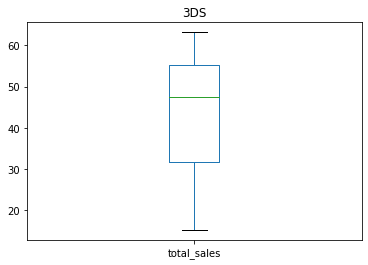

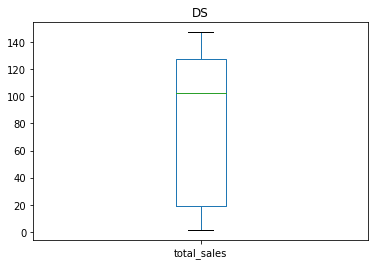

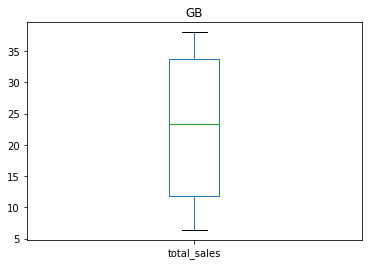

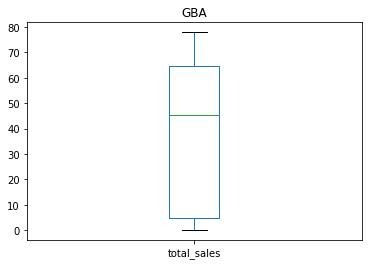

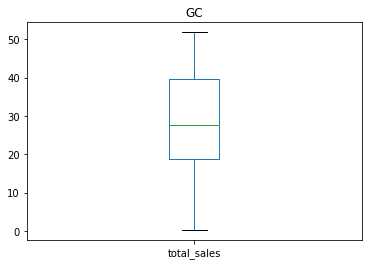

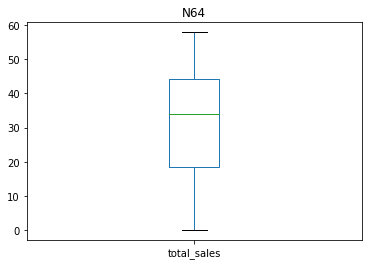

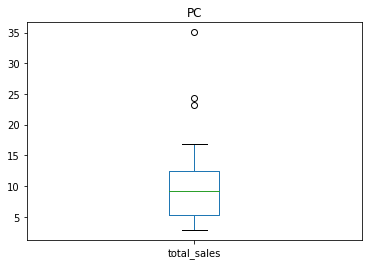

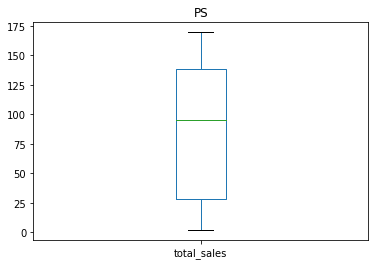

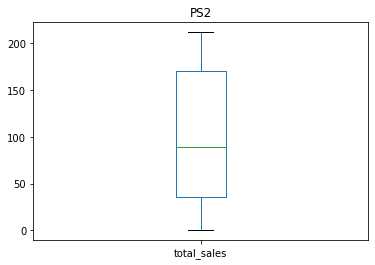

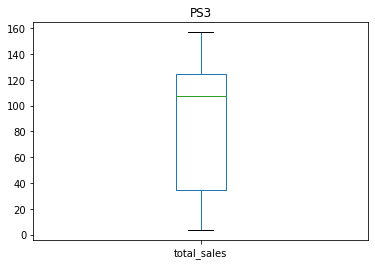

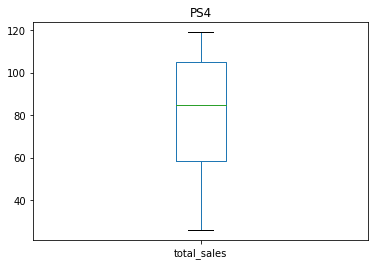

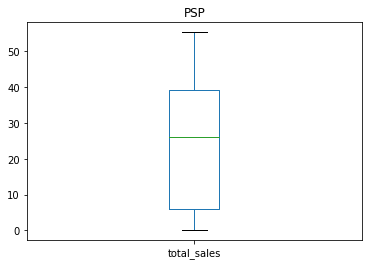

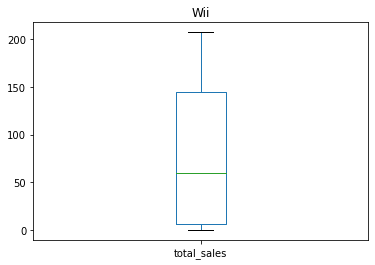

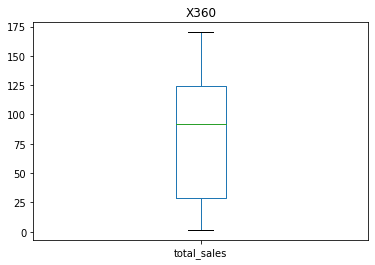

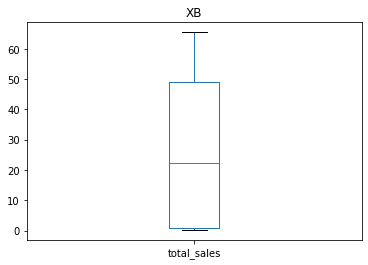

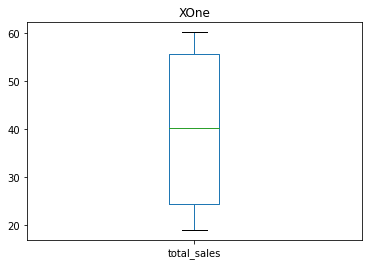

In [44]:
for name, group_data in platform_years_sales.groupby('platform'):
    if name in big_lst:
        group_data.plot(y='total_sales', kind = 'box', title = name)
        plt.show()

Распределение лидера продаж - PS2 -очень близко к нормальному, практически не смещено. Медиана - в районе 80 млн. копий, второй квартиль - от 40 до 170 млн.
Распределение Xbox 360 - менее ровное, датасет чуть скошен влево, медиана на таком же уровне, 80 млн копий, 2 квартиль - от 30 до 125 млн. копий.
PS3 - датасет скошен влево, медиана - на уровне 110 млн. копий, пиковые продажи были на уровне 155 млн. штук.
Wii - сильно скошенный влево датасет, старт продаж был очень интенсивным, медиана - 60 млн. копий, пик продаж - 200 млн.
DS - в отличии от предыдущих платформ распределение DS в меньшей степени похоже на нормальное. Старт продаж был очень интенсивным, на протяжении 6 лет платформа удерживала высокие продажи. Медиана - 100 млн. копий в год, пик - 150 млн.
Из перспективных платформ - распределение РС4 - нормальное со скошенным вправо датасетом. Медиана - на уровне 80 млн. копий, пик - 115 млн. XOne - ровный датасет, чуть скошенный влево, медиана - 40 млн. копий, пик - 60 млн. копий. 3DS - напоминает распределение Пуассона, медиана - 48 млн. копий, пик - 65 млн.
Pаспределение PC - циклично, на графике прослеживается волнообразная тенденция, 3 нормальных распределения. 2016 год - точка спада, дальше, по тенденции, возможен рост продаж. Медиана - на уровне 8 млн. копий, пик - на уровне 34.

### Анализ взаимосвязей продаж игр и оценок критиков и пользователей

### Выделение актуального периода в датафрейме

In [45]:
df=df.query('year_of_release>2013')

In [46]:
score_set_ps3 = df.query('platform == "PS3" and critic_score!=0')

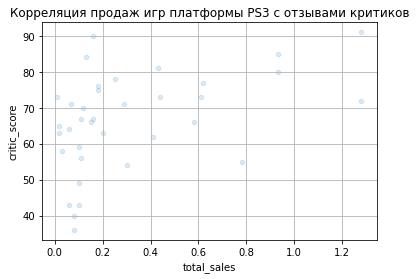

In [47]:
score_set_ps3.plot(x = 'total_sales', y = 'critic_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр платформы PS3 с отзывами критиков');

In [48]:
score_set_ps3['total_sales'].corr(score_set_ps3['critic_score'])

0.44657460493190704

Проверим гипотезу о связи отзывов (оценок) критиков и объемах продаж на платформе PS3. Сформируем датасет продаж платформы PS3 с ненулевыми оценками критиков, построим диаграмму рассеяния и посчитаем корреляцию объемов продаж и оценок критиков. на графике видно, что бестселлеры (от 5 млн копий) имеют оценки от 80 баллов и выше. График иллюстрирует, и коэффициент корреляции показывает умеренную положительную связь объемов продаж с оценками, выставленными критиками (исходя из следующей интерпретации коэффициента корреляции: до 0,3 - слабая связь, до 0,6 - умеренная, от 0,7 до 1 - сильная связь).

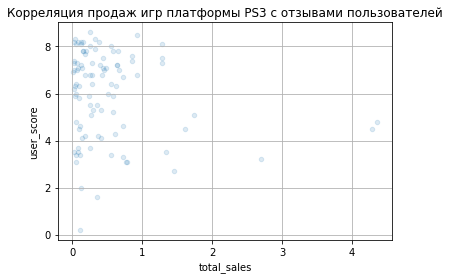

In [49]:
user_score_set_ps3 = df.query('platform == "PS3" and user_score!=0')
user_score_set_ps3.plot(x = 'total_sales', y = 'user_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр платформы PS3 с отзывами пользователей');

In [50]:
score_set_ps3['total_sales'].corr(score_set_ps3['user_score'])

0.1565951618135996

График показывает меньшую связь между оценками пользователей и объемом продаж, чем между оценками критиков и объемом продаж. График с critic_score показывает меньший разброс и большую зависимость оценок и продаж. Коэффициент корреляции продаж и пользовательских оценок равен 0,15, что говорит о слабой связи.

Проанализируем взаимосвязи для тройки перспективных платформ: PS4, XOne и 3DS.Также отдельно проанализируем PC, как платформу, не подходящую под общие закономерности для консолей.

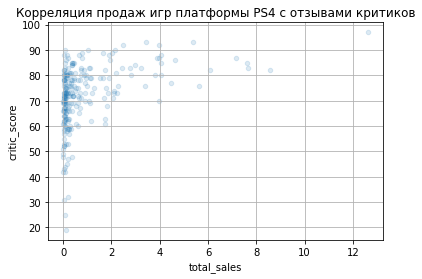

In [51]:
critic_score_set_PS4 = df.query('platform == "PS4" and critic_score!=0')
critic_score_set_PS4.plot(x = 'total_sales', y = 'critic_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр платформы PS4 с отзывами критиков');

In [52]:
critic_score_set_PS4['total_sales'].corr(critic_score_set_PS4['critic_score'])

0.40266141068104083

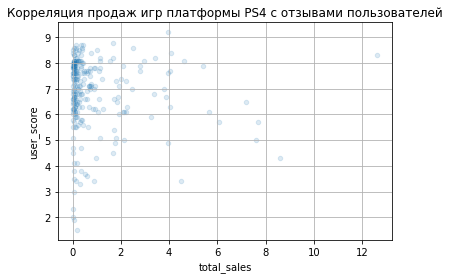

In [53]:
user_score_set_PS4 = df.query('platform == "PS4" and user_score!=0')
user_score_set_PS4.plot(x = 'total_sales', y = 'user_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр платформы PS4 с отзывами пользователей');

In [54]:
user_score_set_PS4['total_sales'].corr(user_score_set_PS4['user_score'])

-0.040131589472697356

Продажи игр на PS4 устойчиво коррелируют с положительными отзывами критиков и абсолютно не коррелируют с отзывами пользователей.

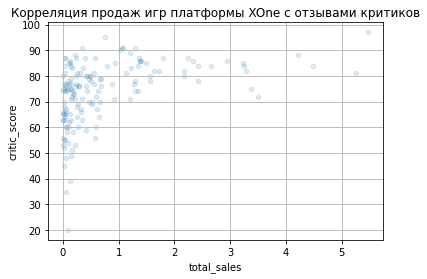

In [55]:
critic_score_set_XOne = df.query('platform == "XOne" and critic_score!=0')
critic_score_set_XOne.plot(x = 'total_sales', y = 'critic_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр платформы XOne с отзывами критиков');

In [56]:
critic_score_set_XOne['total_sales'].corr(critic_score_set_XOne['critic_score'])

0.42867694370333226

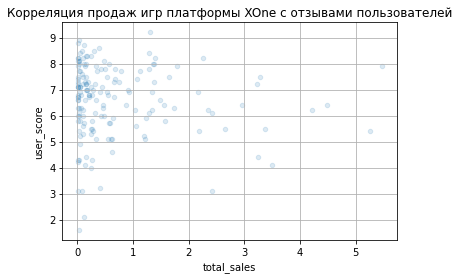

In [57]:
user_score_set_XOne = df.query('platform == "XOne" and user_score!=0')
user_score_set_XOne.plot(x = 'total_sales', y = 'user_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр платформы XOne с отзывами пользователей');

In [58]:
user_score_set_XOne['total_sales'].corr(user_score_set_XOne['user_score'])

-0.0703839280647581

Аналогично PS4 продажи игр на платформе XOne устойчиво коррелируют с отзывами критиков и абсолютно не коррелируют с отзывами игроков.

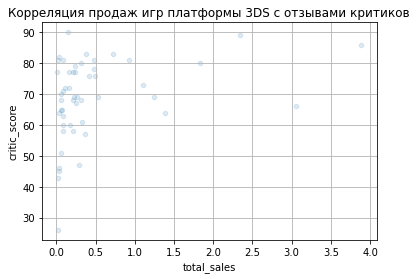

In [59]:
critic_score_set_3DS = df.query('platform == "3DS" and critic_score!=0')
critic_score_set_3DS.plot(x = 'total_sales', y = 'critic_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр платформы 3DS с отзывами критиков');

In [60]:
critic_score_set_3DS['total_sales'].corr(critic_score_set_3DS['critic_score'])

0.31411749286905105

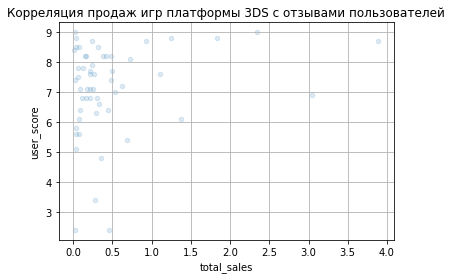

In [61]:
user_score_set_3DS = df.query('platform == "3DS" and user_score!=0')
user_score_set_3DS.plot(x = 'total_sales', y = 'user_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр платформы 3DS с отзывами пользователей');

In [62]:
user_score_set_3DS['total_sales'].corr(user_score_set_3DS['user_score'])

0.2151932718527028

Корреляция с отзывами критиков устойчивая, 0,21.

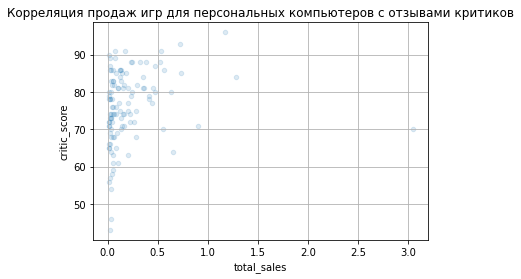

In [63]:
critic_score_set_PC = df.query('platform == "PC" and critic_score!=0')
critic_score_set_PC.plot(x = 'total_sales', y = 'critic_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр для персональных компьютеров с отзывами критиков');

In [64]:
critic_score_set_PC['total_sales'].corr(critic_score_set_PC['critic_score'])

0.17463413769350036

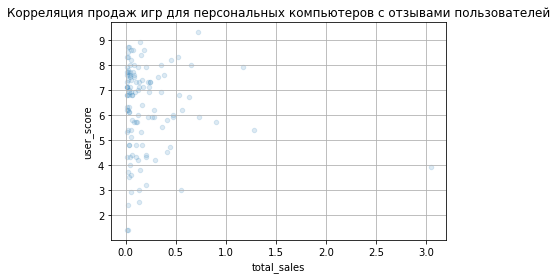

In [65]:
user_score_set_PC = df.query('platform == "PC" and user_score!=0')
user_score_set_PC.plot(x = 'total_sales', y = 'user_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр для персональных компьютеров с отзывами пользователей');

In [66]:
user_score_set_PC['total_sales'].corr(user_score_set_PC['user_score'])

-0.07159665703472452

Проанализируем корреляцию продаж компьютерных игр с отзывами критиков и покупателей. Коэффициент корреляции с отзывами критиков равен 0,17, это ниже, чем коэффициенты для консолей. Коэффициент корреляции с отзывами пользователей - 0,07, говорит о том, что как таковой взаимосвязи между продажами и отзывами пользователей нет.

Выберем в качестве эталонного объекта сравнения поведения продаж и отзывов критиков и пользователей платформу PS4, как актуальную и имеющую максимальное количество релизов среди актуальных. 

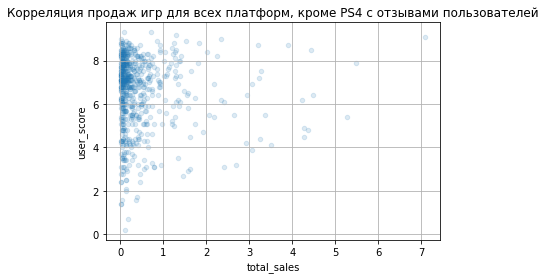

In [67]:
user_score_set_instead_PS4 = df.query('platform != "PS4" and user_score!=0 and year_of_release>2013')
user_score_set_instead_PS4.plot(x = 'total_sales', y = 'user_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр для всех платформ, кроме PS4 с отзывами пользователей');

Сформируем датасет и построим диаграмму рассеяния для всех платформ кроме PS4 за 2014-2016 годы для отзывов пользователей.

In [68]:
user_score_set_instead_PS4['total_sales'].corr(user_score_set_instead_PS4['user_score'])

-0.02347818723797555

Посчитаем коэффициент корреляции. Продажи игр на прочих платформах также абсолютно не коррелируют с отзывами пользователей.

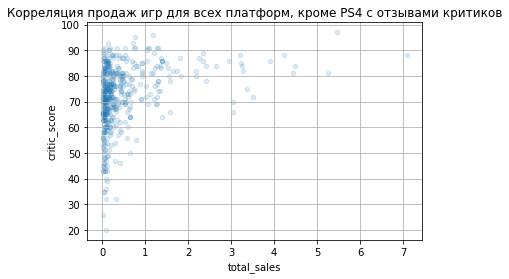

In [69]:
critic_score_set_instead_PS4 = df.query('platform != "PS4" and critic_score!=0 and year_of_release>2013')
critic_score_set_instead_PS4.plot(x = 'total_sales', y = 'critic_score', kind = 'scatter', grid = True,alpha=0.15, title = 'Корреляция продаж игр для всех платформ, кроме PS4 с отзывами критиков');

In [70]:
critic_score_set_instead_PS4['total_sales'].corr(critic_score_set_instead_PS4['critic_score'])

0.3094740026001153

Продажи прочих игр имеют слабую корреляцию с отзывами пользователей.

Вывод: корреляция с отзывами пользователей у популярной платформы PS4 и у всей массы платформ за актуальный период сопоставима, а именно -она отсутствует. Корреляция продаж с оценками критиков выше у популярной платформы PS4 (0,4) нежели у общей массы игр (0,309).

### Формирование рейтинга средних продаж в разрезе жанров

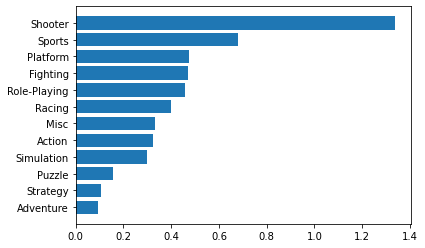

In [71]:
genre_sales = df.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'mean').reset_index().sort_values(by='total_sales', ascending = True)
#genre_sales.plot(x='genre', y='total_sales', kind = 'bar', title = "Распределение игр по жанрам", rot = 16);
plt.barh(genre_sales['genre'],genre_sales['total_sales'] );

Построим гистограмму распределения игр в зависимости от средних продаж. Лидер продаж - жанр Shooter. Platform и RPG  - на втором и третьем месте. Четвертая позиция - гонки, на пятом месте с небольшим отрывом - спортивные игры. Экшены и файтинги имеют почти одинаковые средние продажи. Предпоследние в рейтинге - стратегии и Puzzle. На последнем месте - жанр Adventure.

### Вывод

Массовое развитие игровой индустрии началось в 1994-1996 годах. Это показывают и гистограмма количества новых релизов и гистограмма распределения количества проданных копий. Значительный всплеск по количеству проданных копий игр произошел в 1996 году. Актуальный период для анализа -  с 2014 года и позже.

Анализ показывает, что средний полный цикл жизни платформы равен 8 годам.

Исходя из анализа жизненного цикла можно выделить следующие перспективные для продаж платформы: PS4, XOne, 3DS (жизненный цикл которых еще не завершен). Платформа PC также перспективна, к ней неприменимы понятия жизненного цикла, т.к. персональный компьютер отлилчается от консоли мультифункциональностью, его используют для работы а не только для игр.
Распределения продаж основных платформ в большинстве своем нормальные, с датасетами, скошенными влево. Исключение составляет PС, диаграмма которого показывает цикличность.

В топе по количеству проданных копий - Play Station 2, X360, Play Station 3 и 2 платформы от Nintendo: Wii и DS. Топ за актуальный период - 

Анализ перспективных платформ показал устойчивую взаимосвязь объемов продаж от оценок критиков и почти нулевую корреляцию с пользовательскими оценками. Анализ игр для ПК показал небольшую корреляцию с оценками критиков и нулевую корреляцию с пользовательскими оценками.

Рейтинг игр по объему продаж распределен следующим образом: Shooter, Sports и Platform, аутсайдеры - Adventure, стратегии и паззлы.

## Формирование портрета пользователя каждого региона

### Анализ распределения игр по платформам в разрезе регионов

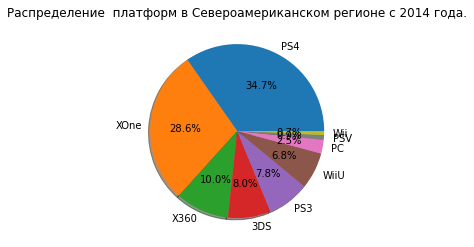

In [72]:
na_set_platform_2014_2016 = (
    df.query('na_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='na_sales', ascending = False)
    
)
plt.title('Распределение  платформ в Североамериканском регионе с 2014 года.')
plt.pie(na_set_platform_2014_2016['na_sales'], labels =na_set_platform_2014_2016['platform'],autopct='%1.1f%%',shadow = True);

Проанализируем распределение продаж в разрезе платформ за актуальный период. Сформируем датасет na_set_platform_2014_2016 и построим круговую диаграмму с распределением долей платформ. Первое место по количеству проданных копий занимает PS4. на втором месте - XOne от Intel. Третье место также занимает интеловская платформа X360.

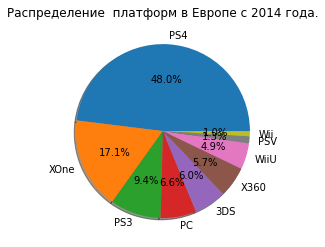

In [73]:
eu_set_platform_2014_2016 = (
    df.query('eu_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='eu_sales', ascending = False)
    
)
plt.title('Распределение  платформ в Европе с 2014 года.')
plt.pie(eu_set_platform_2014_2016['eu_sales'], labels =eu_set_platform_2014_2016['platform'],autopct='%1.1f%%',shadow = True);

Безусловный лидер продаж актуальных игр в Европе - Sony. Второе место - XOne. Третье - PS3.

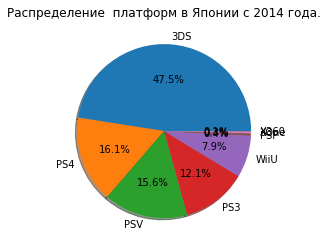

In [74]:
jp_set_platform_2014_2016 = (
    df.query('jp_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='jp_sales', ascending = False)
    
)
plt.title('Распределение  платформ в Японии с 2014 года.')
plt.pie(jp_set_platform_2014_2016['jp_sales'], labels =jp_set_platform_2014_2016['platform'],autopct='%1.1f%%',shadow = True);

Безусловный лидер продаж актуальных игр в Японии - корпорация Nintendo. Второе место - продажи игр для Play Statoin 4, PSV и PS3. 

### Анализ распределения игр по жанрам

Проанализируем региональные предпочтения по жанрам.

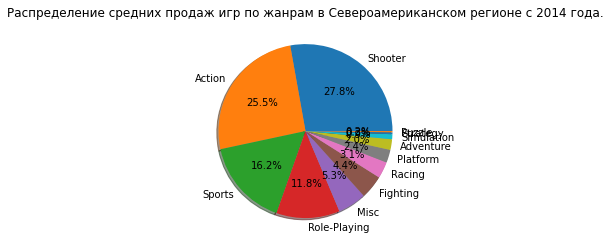

In [75]:
na_set_genre_2014_2016 = (
    df.query('na_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='na_sales', ascending = False)
    
)
plt.title('Распределение средних продаж игр по жанрам в Североамериканском регионе с 2014 года.')
plt.pie(na_set_genre_2014_2016['na_sales'], labels =na_set_genre_2014_2016['genre'],autopct='%1.1f%%',shadow = True);

Предпочтения американских геймеров отличны от глобальных, шутеры - на первом месте, экшены - на втором, спортивные игры - на третьем.

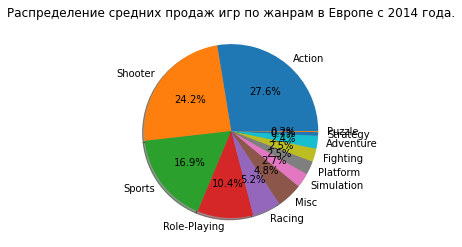

In [76]:
eu_set_genre_2014_2016 = (
    df.query('eu_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='eu_sales', ascending = False)
    
)
plt.title('Распределение средних продаж игр по жанрам в Европе с 2014 года.')
plt.pie(eu_set_genre_2014_2016['eu_sales'], labels =eu_set_genre_2014_2016['genre'],autopct='%1.1f%%',shadow = True);

Распределение предпочтений по жанрам в Европе распределено следующим образом: экшкены, шутеры, спортивные игры.

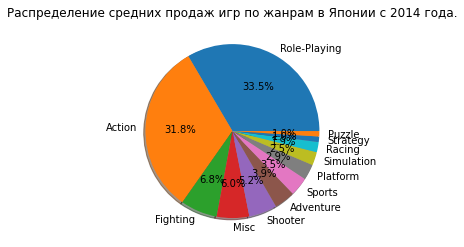

In [77]:
jp_set_genre_2014_2016 = (
    df.query('jp_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='jp_sales', ascending = False)
    
)
plt.title('Распределение средних продаж игр по жанрам в Японии с 2014 года.')
plt.pie(jp_set_genre_2014_2016['jp_sales'], labels =jp_set_genre_2014_2016['genre'],autopct='%1.1f%%',shadow = True);

Предпочтения японских геймеров отличаются от предпочтений европейских и американских кардинально. 33,5%% занимают игры жанра RPG, не представленные в ТОП-3 США и Европы. Экшены и файтинги - на втором и третьем местах.

### Анализ распределения игр по рейтингам

In [78]:
df['rating'].value_counts()

0       749
T       271
M       265
E       219
E10+    185
Name: rating, dtype: int64

Предлагается сравнить долю продаж игр для каждого региона со средними продажами без рейтинга.

Крупнейшие доли представлены следующими рейтингами (информация о рейтингах взята из Википедии):

-E («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера.

-E10+ («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови.

-T («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

-M («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие и сцены, нежелательные для младшей аудитории.

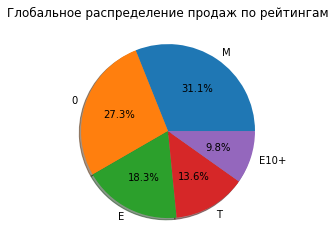

In [79]:
world_set_rating = (
    df.query('year_of_release>2013')
    .pivot_table(index = 'rating', values = 'total_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='total_sales', ascending = False)
    
)
plt.title('Глобальное распределение продаж по рейтингам')
plt.pie(world_set_rating['total_sales'], labels =world_set_rating['rating'],autopct='%1.1f%%',shadow = True);

В глобальном рейтинге наибольшую долю занимают продажи игр для возрослых. Второе место занимают игры без рейтинга.  

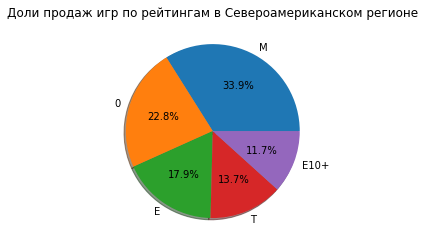

In [80]:
na_set_rating = (
    df.query('na_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='na_sales', ascending = False)
    
)
plt.title('Доли продаж игр по рейтингам в Североамериканском регионе')
plt.pie(na_set_rating['na_sales'], labels =na_set_rating['rating'],autopct='%1.1f%%',shadow = True);

Распределение по рейтингам в США аналогично глобальному, треть игр - для взрослых, вторая и третья позиция - игры бер рейтинга и Everyone.

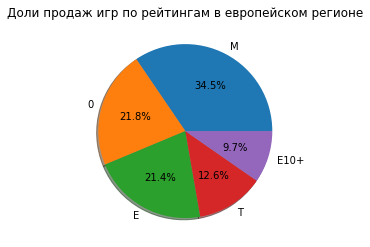

In [81]:
eu_set_rating = (
    df.query('eu_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='eu_sales', ascending = False)
    .head(5)
)
plt.title('Доли продаж игр по рейтингам в европейском регионе')
plt.pie(eu_set_rating['eu_sales'], labels =eu_set_rating['rating'],autopct='%1.1f%%',shadow = True);

Распределение почти идентично картине в Североамериканском регионе, доля игр для взрослых больше на 1%

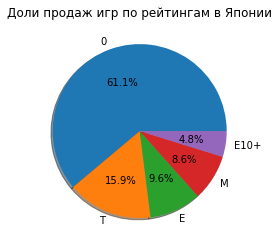

In [82]:
jp_set_rating = (
    df.query('jp_sales!=0 and year_of_release>2013')
    .pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum')
    .reset_index()
    .sort_values(by='jp_sales', ascending = False)
    .head(5)
)
plt.title('Доли продаж игр по рейтингам в Японии')
plt.pie(jp_set_rating['jp_sales'], labels =jp_set_rating['rating'],autopct='%1.1f%%',shadow = True);

Структура японского рынка отличается от общемирового, европейского и американского. 61,1% проданных там игр не имеют рейтинга ESRB. Скорее всего такая доля - следствие того, что ESRB изначально была основана для определения рейтингов игр США и Канады. Но если посмотреть на распределение долей игр для взрослых, можно выдвинуть гипотезу, что японские пользователи стараются избегать игр с большим количеством насилия и ненормативной лексики, на первом месте игр с рейтингом стоят Teen, на втором - Everyone и только на третьем - Mature.

### Вывод

Максимально распространенная на американском рынке платформа - Play Station. На втором месте - XBox от Microsoft, третья в рейтинге - X360. Позиции Microsoft традиционно сильны в "домашнем" регионе. Жанровые предпочтения выстроены в следующем порядке: Shooter, Action, Sports, RPG, Misc. Рейтинг ESRB не имеет большого влияния на продажи, больших отличий от глобального распределения нет.

Европейский пользователь в большинстве своем выбирает Play Station, на втором месте - XOne, на третьем - PC3. Жанровые предпочтения Action, Shooter, Sports, RPG, Racing. Структура продаж и выводы в части рейтинга ESRB у американского и европейского пользователя идентичны.

У японского пользователя уверенный лидер- корпорация Nintendo. Второе и третье место занимают Play Station4 и PSV. Четвертое место по объему - PS3. Американский XBox не попал в пятерку лидеров японского рынка. Жанровые предпочтения кардинально отличаются от американского и европейского пользователя: на первом месте игры жанра RPG. Action, файтинги, Misc и шутеры - на 2,3, 4 и 5 позициях.
61,1% проданных там игр не имеют рейтинга ESRB. Скорее всего такая доля - следствие того, что ESRB изначально была основана для определения рейтингов игр США и Канады. На втором месте - игры, разрешенные тинэйджерам, далее - категория Everyone. Предположительно, японские пользователи стараются избегать игр с большим количеством насилия и ненормативной лексики.

## Проверка гипотез.

### Проверка гипотезы: "пользовательские рейтинги платформ Xbox One и PC одинаковые"

Сформируем датасеты для проверки гипотезы "пользовательские рейтинги платформ Xbox One и PC одинаковые". Так как нулевая гипотеза всегда формируется так, чтобы использовать знак равенства, она будет звучать также: "пользовательские рейтинги платформ Xbox One и PC одинаковые. Альтернативная гипотеза - "пользовательские рейтинги платформ Xbox One и PC различаются".

In [83]:
XOne_raiting = df.query('user_score!=0 and platform=="XOne"')

In [84]:
PC_raiting = df.query('user_score!=0 and platform=="PC"')

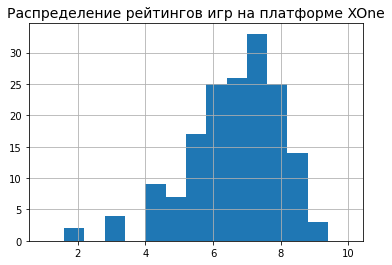

In [85]:
XOne_raiting['user_score'].hist(bins = 15, range = (1,10));
plt.title('Распределение рейтингов игр на платформе XOne', fontsize = 14);

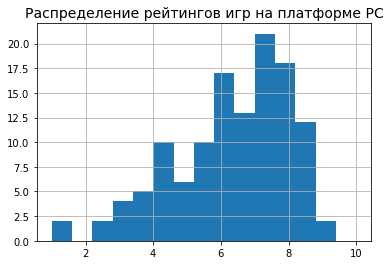

In [86]:
PC_raiting['user_score'].hist(bins = 15, range = (1,10));
plt.title('Распределение рейтингов игр на платформе PC', fontsize = 14);

Построим графики распределений для оценки распределений средних рейтингов на платформах XOne и РС.

In [87]:
XOne_variance_user_score = np.var(XOne_raiting['user_score'], ddof=1)
PC_variance_user_score = np.var(PC_raiting['user_score'], ddof=1)

In [88]:
XOne_variance_user_score

1.8910066518846989

In [89]:
PC_variance_user_score

2.9011543151334522

Сравним дисперсии выборок выручки двух платформ для того, чтобы решить какое значение присваивать параметру equal_var. Если дисперсии выборок равны, необходимо присваивать True, если различаются, то False. В нашем случае параметр будет False, дисперсии не равны.

In [90]:
alpha = 0.05
results = st.ttest_ind(XOne_raiting['user_score'], PC_raiting['user_score'],equal_var = False)

In [91]:
results.pvalue

0.11601398086668832

In [92]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Проведем t-test, сравнив средние распределения рейтингов. P-value больше стандартного параметра alpha, средние рейтинги игр платформ XOne и РС схожи.

In [93]:
action_rating = df.query('genre == "Action" and user_score!=0 and year_of_release>2013')
sports_rating = df.query('genre == "Sports" and user_score!=0 and year_of_release>2013')

### Проверка гипотезы: "пользовательские рейтинги жанров Action и Sports разные"

Сформируем датасеты для проверки гипотезы "пользовательские рейтинги жанров Action и Sports разные". Так как нулевая гипотеза всегда формируется так, чтобы использовать знак равенства, она будет звучать также: пользовательские рейтинги жанров Action и Sports одинаковые. Альтернативная гипотеза - "пользовательские рейтинги жанров Action и Sports различаются".

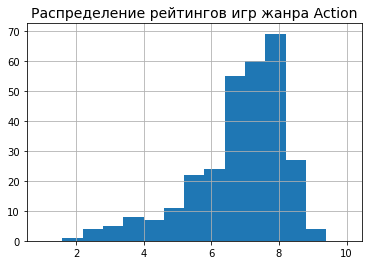

In [94]:
action_rating['user_score'].hist(bins = 15, range = (1,10));
plt.title('Распределение рейтингов игр жанра Action', fontsize = 14);

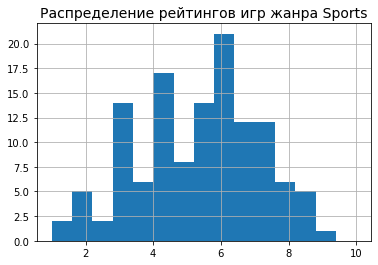

In [95]:
sports_rating['user_score'].hist(bins = 15, range = (1,10));
plt.title('Распределение рейтингов игр жанра Sports', fontsize = 14);

Оба распределения похожи на нормальные, скошенные вправо (в сторону больших оценок).

In [96]:
action_rating_user_score = np.var(action_rating['user_score'], ddof=1)
sports_rating_user_score = np.var(sports_rating['user_score'], ddof=1)

In [97]:
action_rating_user_score

1.898476658476659

In [98]:
sports_rating_user_score

3.4469791276090476

Сравним дисперсии выборок выручки жанров для того, чтобы решить какое значение присваивать параметру equal_var. Значения не равны, equal_var = False

In [99]:
alpha = 0.05
results = st.ttest_ind(action_rating['user_score'], sports_rating['user_score'],equal_var = False)

In [100]:
results.pvalue

1.1825550382644557e-14

In [101]:
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Проведем t-test. Нулевую гипотезу отвергаем, пользовательские оценки жанров action и sports различаются.

## Общий вывод

Массовое развитие игровой индустрии началось в 1994-1996 годах. Это показывают и гистограмма количества новых релизов и гистограмма распределения количества проданных копий. Значительный всплеск по количеству проданных копий игр произошел в 1996 году. Актуальный период для анализа - с 1996 года и позже.

Анализ показывает, что средний полный цикл жизни платформы равен 8 годам.

Исходя из анализа жизненного цикла можно выделить следующие перспективные для продаж платформы: PS4, XOne, 3DS (жизненный цикл которых еще не завершен). Платформа PC также перспективна, к ней неприменимы понятия жизненного цикла, т.к. персональный компьютер отлилчается от консоли мультифункциональностью, его используют для работы а не только для игр. Распределения продаж основных платформ в большинстве своем нормальные, с датасетами, скошенными влево. Исключение составляет PС, диаграмма которого показывает цикличность.

В топе по количеству проданных копий за актуальный период - PS4, XOne и 3DS от Nintendo.

Анализ перспективных платформ показал устойчивую взаимосвязь объемов продаж от оценок критиков и почти нулевую корреляцию с пользовательскими оценками. Анализ игр для ПК показал небольшую корреляцию с оценками критиков и нулевую корреляцию с пользовательскими оценками.
Было проведено сравнение корреляции продаж и отзывов критиков и пользователей всех платформ и популярной платформы PS4. Вывод: корреляция с отзывами пользователей у популярной платформы PS4 и у всей массы платформ за актуальный период сопоставима, а именно -она отсутствует.

Рейтинг игр по объему продаж распределен следующим образом: лидер продаж - жанр Shooter. Sports, Platform и Fighting  - на втором, третьем и четвертом месте. На пятом месте RPG. Предпоследние в рейтинге - стратегии и Puzzle. На последнем месте - жанр Adventure.

Максимально распространенная на американском рынке платформа - Play Station. На втором месте - XBox от Microsoft, третья в рейтинге - X360. Позиции Microsoft традиционно сильны в "домашнем" регионе. Жанровые предпочтения выстроены в следующем порядке: Shooter, Action, Sports, RPG, Misc. Рейтинг ESRB не имеет большого влияния на продажи, больших отличий от глобального распределения нет.

Европейский пользователь в большинстве своем выбирает Play Station, на втором месте - XOne, на третьем - PC3. Жанровые предпочтения Action, Shooter, Sports, RPG, Racing. Структура продаж и выводы в части рейтинга ESRB у американского и европейского пользователя идентичны.

У японского пользователя уверенный лидер- корпорация Nintendo. Второе и третье место занимают Play Station4 и PSV. Четвертое место по объему - PS3. Американский XBox не попал в пятерку лидеров японского рынка. Жанровые предпочтения кардинально отличаются от американского и европейского пользователя: на первом месте игры жанра RPG. Action, файтинги, Misc и шутеры - на 2,3, 4 и 5 позициях.
61,1% проданных там игр не имеют рейтинга ESRB. Скорее всего такая доля - следствие того, что ESRB изначально была основана для определения рейтингов игр США и Канады. На втором месте - игры, разрешенные тинэйджерам, далее - категория Everyone. Предположительно, японские пользователи стараются избегать игр с большим количеством насилия и ненормативной лексики.

Гипотеза о равенстве средних рейтингов игр платформ XOne и РС подтверждается. Гипотеза о неравенстве средних оценок жанров Action и Sports подтверждается, пользовательские оценки жанров Action и Sports различны.

Рекомендации для магазина "Стримчик" на основе проведенного анализа следующие:

1)Максимально делать ставки на продажи игр для PS4, XOne и 3DS

2)В большей степени выбирать игры с высокими оценками критиков и не брать в расчет оценки и отзывы пользователей

3)Для американского рынка ориентироваться в равной степени на платформу XOne и PS4, обращать внимание на рейтинг популярности по жанрам (Shooter, Action, Sports, RPG, Misc) вне зависимости от рейтинга ESRB.

4)Для европейского рынка, аналогично североамериканскому, закупать игры для XOne и PS4, иметь в виду рейтинг жанров(Action, Shooter, Sports, RPG, Racing).

5)Учитывать специфичность японского рынка игр, в большей степени ориентироваться на игры для Nintendo и PS4, учитывать локализованность, игры для XBox не будут пользоваться спросом в Японии. В первую очередь ориентироваться на жанр RPG, Action, файтинги, Misc и шутеры. Обращать внимание на рейтинг ESRB (или его отсутствие) и не предлагать игры со слишком откровенными сценами насилия и большим количеством ненормативной лексики.